<h1>Spacial density of Na and K in various traps</h1>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from typing import Union
from astropy.units import Quantity
from typing import Union, Sequence

from astropy.constants import hbar, k_B

from LightMat import BoseGas, FermiGas, ParticleProps

import scipy
from tqdm import tqdm

In [7]:
def harmonic_trap(
        x: Union[float, np.ndarray, Quantity],
        y: Union[float, np.ndarray, Quantity],
        z: Union[float, np.ndarray, Quantity],
        trap_depth: Union[float, Quantity] = 200,
        waist: Union[float, Quantity] = 50,
        inhomogenity: float = 0.01
    ) -> Union[float, np.ndarray]:
    """Return a harmonic trap potential in [k_B x nK] for given position(s) in [μm].
    
        Args:
            x, y, z: position in [μm]
            trap_depth: trap depth in [k_B x nK]. Defaults to 200nK.
            waist: region in which we can model the trap as harmonic is [-waist, waist] in [μm]. Defaults to 50μm.
            inhomogenity: This number times `trap_depth` gives the noise magnitude.

        Returns:
            V(x, y, z): harmonic trap potential in [k_B x nK], array of same shape as x, y, z
    """
    if isinstance(x, Quantity) and x.unit.is_equivalent(u.um):
        x = x.to(u.um).value
    if isinstance(y, Quantity) and y.unit.is_equivalent(u.um):
        y = y.to(u.um).value
    if isinstance(z, Quantity) and z.unit.is_equivalent(u.um):
        z = z.to(u.um).value
    if isinstance(trap_depth, Quantity) and trap_depth.unit.is_equivalent(u.nK):
        trap_depth = trap_depth.to(u.nK).value
    if isinstance(waist, Quantity) and waist.unit.is_equivalent(u.um):
        waist = waist.to(u.um).value
    # Create Gaussian profile
    r_squared = x**2 + y**2 + z**2
    gaussian_profile = np.exp(-2 * r_squared / waist**2)

    # Apply the potential: -trap_depth at the center, 0 at the edges
    perfect_harmonic_trap = -trap_depth * gaussian_profile

    # Add noise
    np.random.seed(42)
    noise = np.random.rand(*perfect_harmonic_trap.shape, ) * inhomogenity * trap_depth
    return perfect_harmonic_trap + noise


def box_trap(
        x: Union[float, np.ndarray, Quantity],
        y: Union[float, np.ndarray, Quantity],
        z: Union[float, np.ndarray, Quantity],
        trap_depth: Union[float, Quantity] = 200.,
        box_width: Union[float, Sequence[float], Quantity] = (100., 100., 100.),
        inhomogenity: float = 0.01
) -> Union[float, np.ndarray]:
    """Return a perfect box potential of depth `trap_depth` in [k_B x nK] for given position(s) in [μm].
       The size of the box in each direction around 0 is given by `box_width` in [μm].
    
        Args:
            x, y, z: position in [μm]
            trap_depth: box depth in [k_B x nK]. Defaults to 200nK.
            box_width: region [-box_width/2 μm, box_width/2 μm] is -`trap_depth`nK, else potential is 0nK.
                       Defaults to (100, 100, 100)μm.
            inhomogenity: This number times `trap_depth` gives the noise magnitude.

        Returns:
            V(x, y, z): box potential in [k_B x nK], array of same shape as x, y, z
    """
    if isinstance(x, Quantity) and x.unit.is_equivalent(u.um):
        x = x.to(u.um).value
    if isinstance(y, Quantity) and y.unit.is_equivalent(u.um):
        y = y.to(u.um).value
    if isinstance(z, Quantity) and z.unit.is_equivalent(u.um):
        z = z.to(u.um).value
    if isinstance(trap_depth, Quantity) and trap_depth.unit.is_equivalent(u.nK):
        trap_depth = trap_depth.to(u.nK).value
    if isinstance(box_width, Quantity) and box_width.unit.is_equivalent(u.um):
        box_width = box_width.to(u.um).value
    if isinstance(box_width, (int, float)):
        box_width = (box_width, box_width, box_width)
    # Check if the positions are within the box
    in_box = (np.abs(x) <= box_width[0] / 2) & \
             (np.abs(y) <= box_width[1] / 2) & \
             (np.abs(z) <= box_width[2] / 2)

    # Apply the potential: -trap_depth inside the box, 0 outside
    perfect_box = np.where(in_box, -trap_depth, 0.)

    # Add noise
    np.random.seed(42)
    noise = np.random.rand(*perfect_box.shape) * inhomogenity * trap_depth
    return perfect_box + noise

In [2]:
blue_trap_height_K = 1000/3   # for Na: *3
red_trap_depth_K = 90*17 # for Na: /17
inhom = 0.005
central_height = 0

k40 = ParticleProps(
    name="K40",
    species="fermion",
    m=39.963999*u.u,
    N_particles=90000,
    T=15*u.nK,
    domain=(-60, 60)*u.um,
    #V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    #trap_depth=17*100,
    #box_width=(100,100,100),
    #waist=50,
    V_trap=ring_beam_trap,
    blue_trap_height=blue_trap_height_K,
    red_trap_depth=red_trap_depth_K,
    central_height=central_height,
    #inhomogeneity=inhom,
)

na23 = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=114000,
    T=15*u.nK,
    a_s=2.75*u.nm,
    domain=(-60, 60)*u.um,
    #V_trap=harmonic_trap,
    #V_trap=box_trap,
    #V_trap=box_2d_harmonic_1d_trap,
    #trap_depth=100,
    #box_width=(100,100,100),
    #waist=50,
    V_trap=ring_beam_trap,
    blue_trap_height=3*blue_trap_height_K,
    red_trap_depth=red_trap_depth_K/17,
    central_height=central_height,
    #inhomogeneity=inhom,
)

#k40.plot_V_trap()
#na23.plot_V_trap()

In [3]:
fg = FermiGas(k40)
fg.eval_density(use_TF_or_LDA=True)

Perform zero temperature calculation with TF approximaiton for initialization.
Calculate n with LDA...


  4%|▍         | 40/1000 [02:08<51:29,  3.22s/it]  

Convergence reached after 40 iterations.


In [4]:
bg = BoseGas(na23)
bg.eval_density(use_TF=True)

Perform zero temperature calculation with TF and HF approximaiton for initialization.
Calculate n0 with TF approximation and n_ex with semiclassical HF approximation...


  6%|▌         | 6/100 [00:19<05:08,  3.28s/it]

Convergence reached after 6 iterations.


In [5]:
bg.n_array.shape

(1030301,)

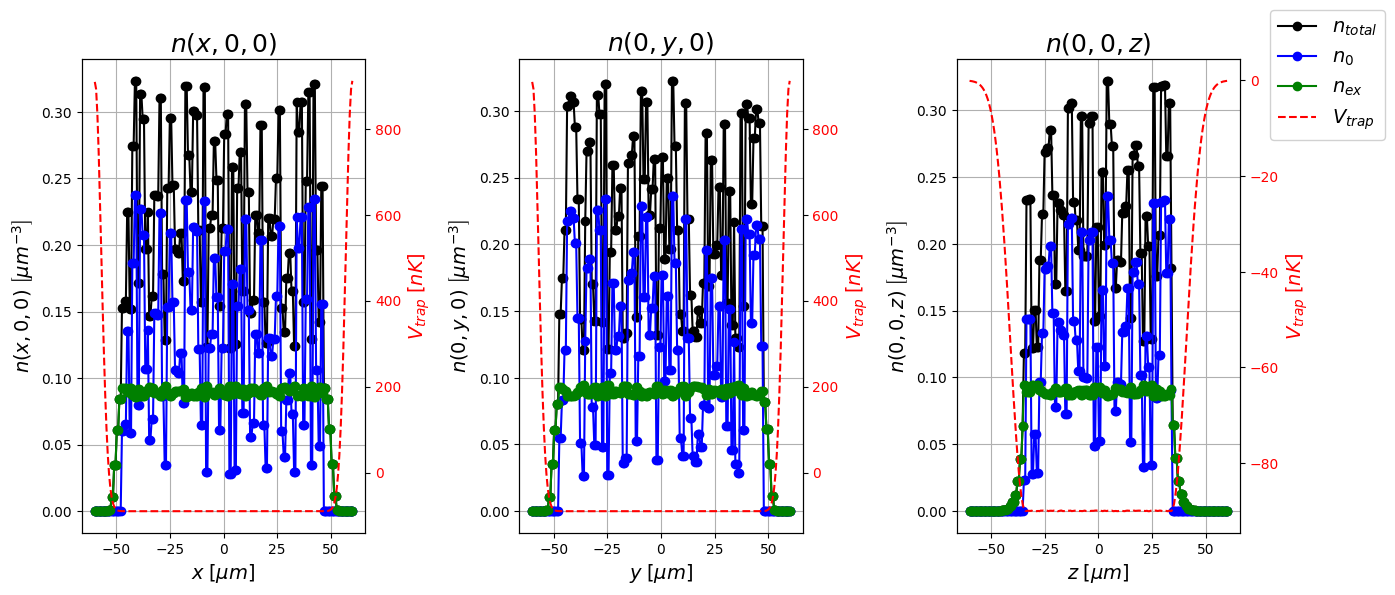

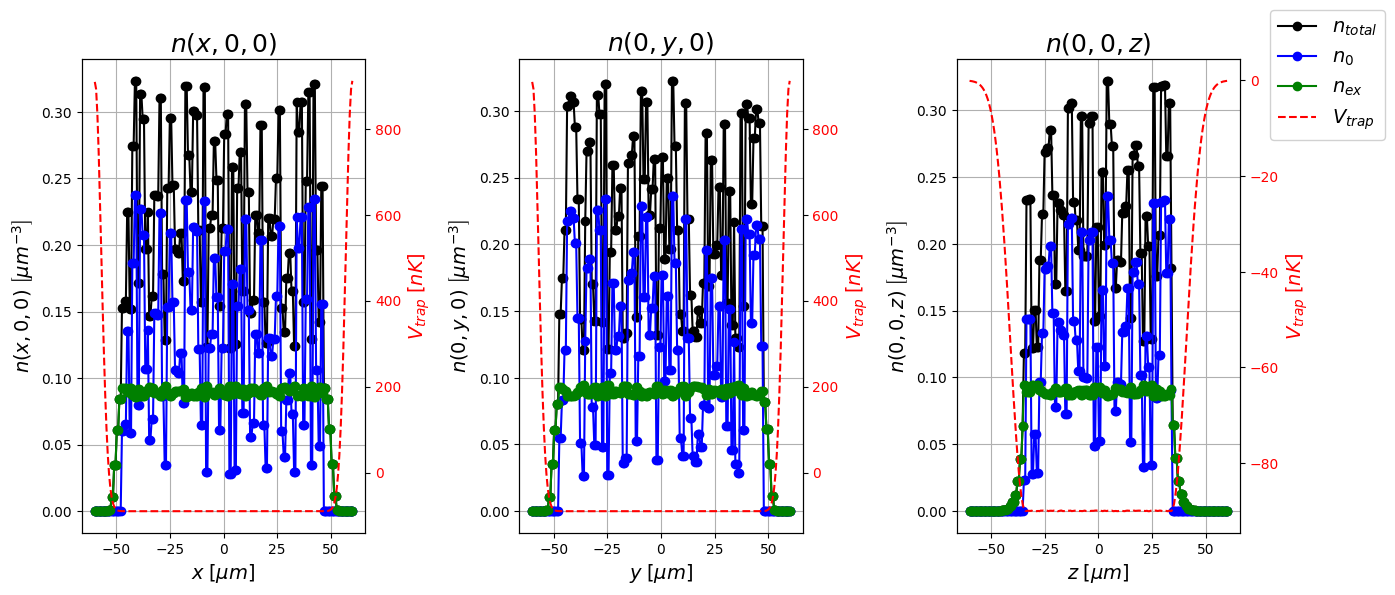

In [6]:
bg.plot_density_1d(which='n', title = "", filename="sodium_density_1d_T10.png")

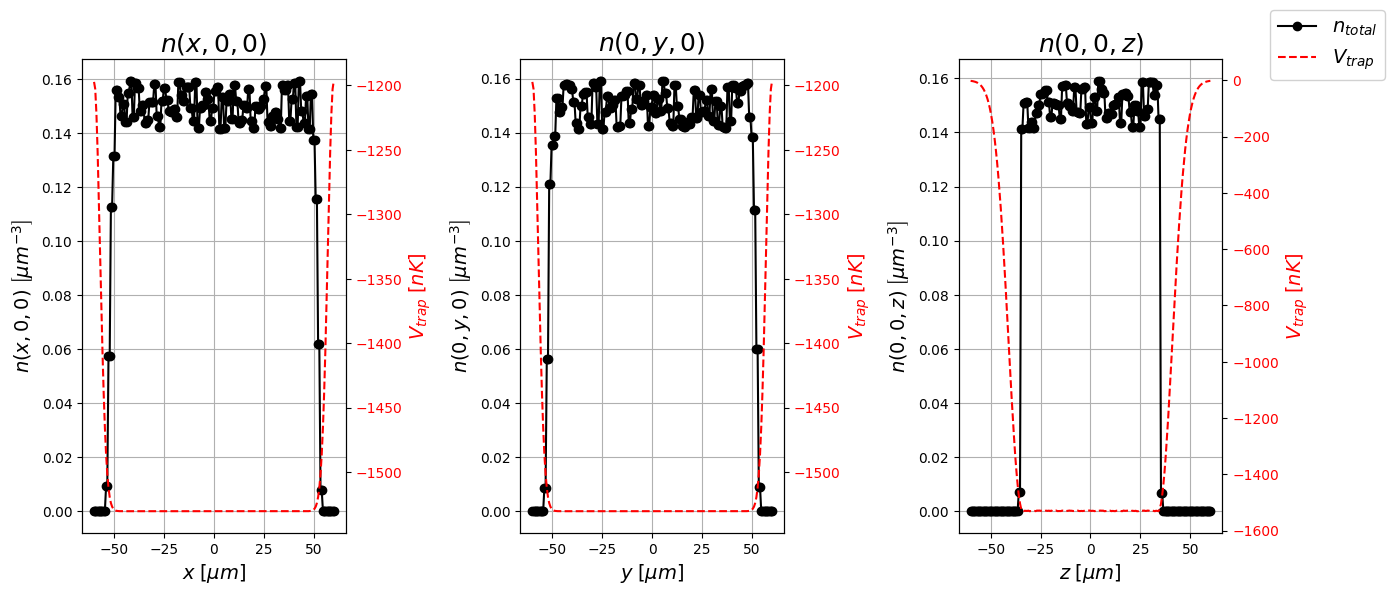

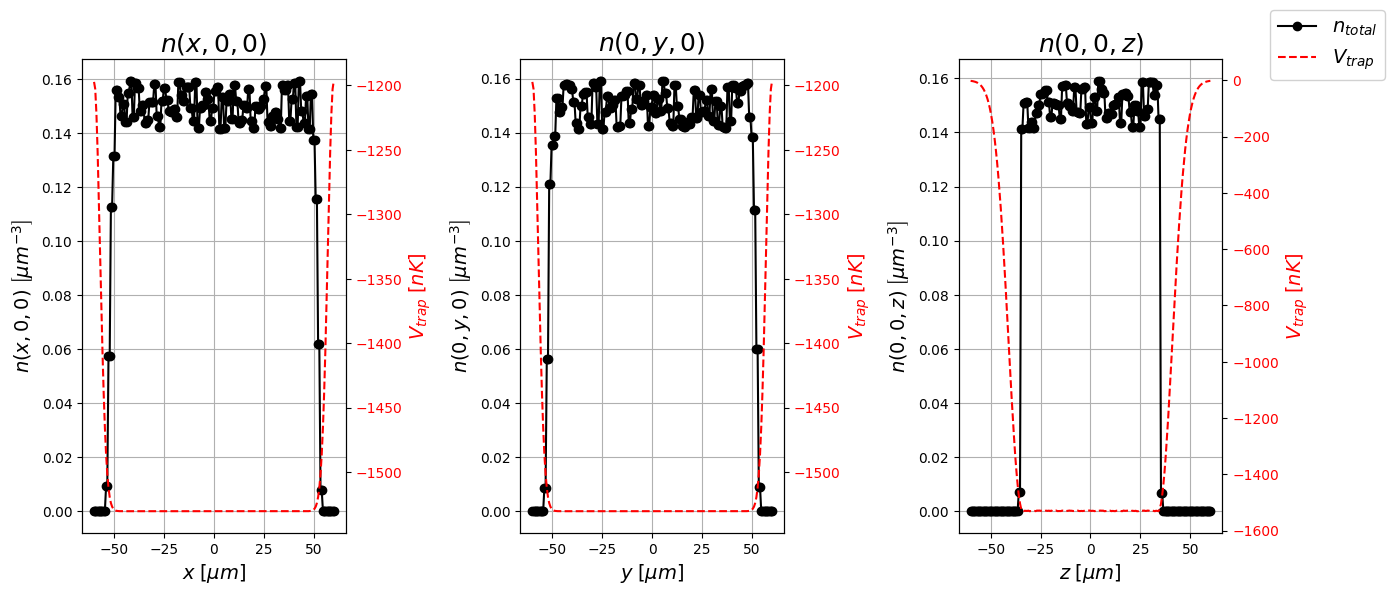

In [7]:
fg.plot_density_1d( title = "", filename="potassium_density_1d_T0.png")

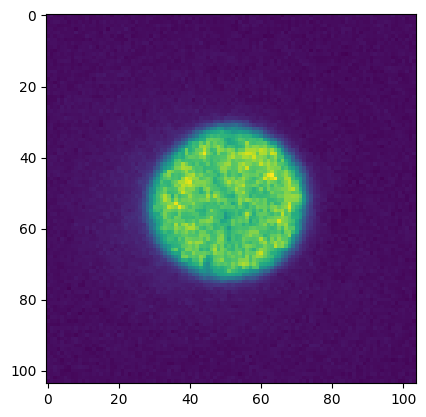

In [7]:
import numpy as np
import matplotlib.pyplot as plt

path = "/home/lelo/Downloads/"

k_data = np.load(path + "density_K.npy")
na_data = np.load(path + "density_Na.npy")

plt.imshow(k_data[:, :, 0])

In [8]:
k_data.shape

(104, 104, 40)

<h2> Density matching </h2>

In [ ]:
num_points = 201

x = np.linspace(fg.particle_props.domain[0, 0].value, fg.particle_props.domain[0, 1].value, num_points)
y = np.linspace(fg.particle_props.domain[1, 0].value, fg.particle_props.domain[1, 1].value, num_points)
z = np.linspace(fg.particle_props.domain[2, 0].value, fg.particle_props.domain[2, 1].value, num_points)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

fg_n = fg.spatial_basis_set.expand_coeffs(fg.n_array, X, Y, Z)
bg_n = bg.spatial_basis_set.expand_coeffs(bg.n_array, X, Y, Z)

In [ ]:
def plot_overlap(bg, fg, central_height):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('K40 and Na23 density matching, T=0, N=100000, inhom=' + str(k40.inhomogeneity*100) + "%" + r", $\omega = 5\mu m$, $h="+str(central_height)+r"nK$", fontsize=24)
    fig.tight_layout(pad=1.5)

    axs[0].plot(x, fg_n[:, num_points//2, num_points//2], label='K40 Fermi gas', marker='o')
    axs[0].plot(x, bg_n[:, num_points//2, num_points//2], label='Na23 Bose gas', marker='o')
    axs[0].set_xlabel('x [μm]', fontsize=14)
    axs[0].set_ylabel(r'n [$μm^{-3}$]', fontsize=14)
    axs[0].set_title('n(x, 0, 0)', fontsize=18)
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(y, fg_n[num_points//2, :, num_points//2], label='K40 Fermi gas', marker='o')
    axs[1].plot(y, bg_n[num_points//2, :, num_points//2], label='Na23 Bose gas', marker='o')
    axs[1].set_xlabel('y [μm]', fontsize=14)
    axs[1].set_ylabel(r'n [$μm^{-3}$]', fontsize=14)
    axs[1].set_title('n(0, y, 0)', fontsize=18)
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(z, fg_n[num_points//2, num_points//2, :], label='K40 Fermi gas', marker='o')
    axs[2].plot(z, bg_n[num_points//2, num_points//2, :], label='Na23 Bose gas', marker='o')
    axs[2].set_xlabel('z [μm]', fontsize=14)
    axs[2].set_ylabel(r'n [$μm^{-3}$]', fontsize=14)
    axs[2].set_title('n(0, 0, z)', fontsize=18)
    axs[2].legend()
    axs[2].grid(True)

    plt.savefig("./plots/20240130_density_matching_" + str(k40.inhomogeneity*100) + ".png", dpi=300, bbox_inches='tight')

In [ ]:
bgs = []
fgs = []

for central_height in [0, 1, 2, 3, 4, 5]:
    na23 = ParticleProps(
        name="Na23",
        species="boson",
        m=22.989768*u.u,
        N_particles=100000,
        T=0, #15*u.nK,
        a_s=2.75*u.nm,
        domain=(-40, 40)*u.um,
        #V_trap=harmonic_trap,
        #V_trap=box_trap,
        #V_trap=box_2d_harmonic_1d_trap,
        #trap_depth=100,
        #box_width=(100,100,100),
        #waist=50,
        V_trap=ring_beam_trap,
        blue_trap_height=3*blue_trap_height_K,
        red_trap_depth=red_trap_depth_K/17,
        central_height=central_height,
        inhomogeneity=0,
    )

    k40 = ParticleProps(
        name="K40",
        species="fermion",
        m=39.963999*u.u,
        N_particles=100000,
        T=0, #45*u.nK,
        domain=(-40, 40)*u.um,
        #V_trap=harmonic_trap,
        #V_trap=box_trap,
        #V_trap=box_2d_harmonic_1d_trap,
        #trap_depth=17*100,
        #box_width=(100,100,100),
        #waist=50,
        V_trap=ring_beam_trap,
        blue_trap_height=blue_trap_height_K,
        red_trap_depth=red_trap_depth_K,
        central_height=central_height,
        inhomogeneity=0,
    )

    bg = BoseGas(na23)
    bg.eval_density(use_TF=False)
    bgs.append(bg)

    fg = FermiGas(k40)
    fg.eval_density(use_TF_or_LDA=False)
    fgs.append(fg)

   

TypeError: ring_beam_trap() got an unexpected keyword argument 'inhomogeneity'

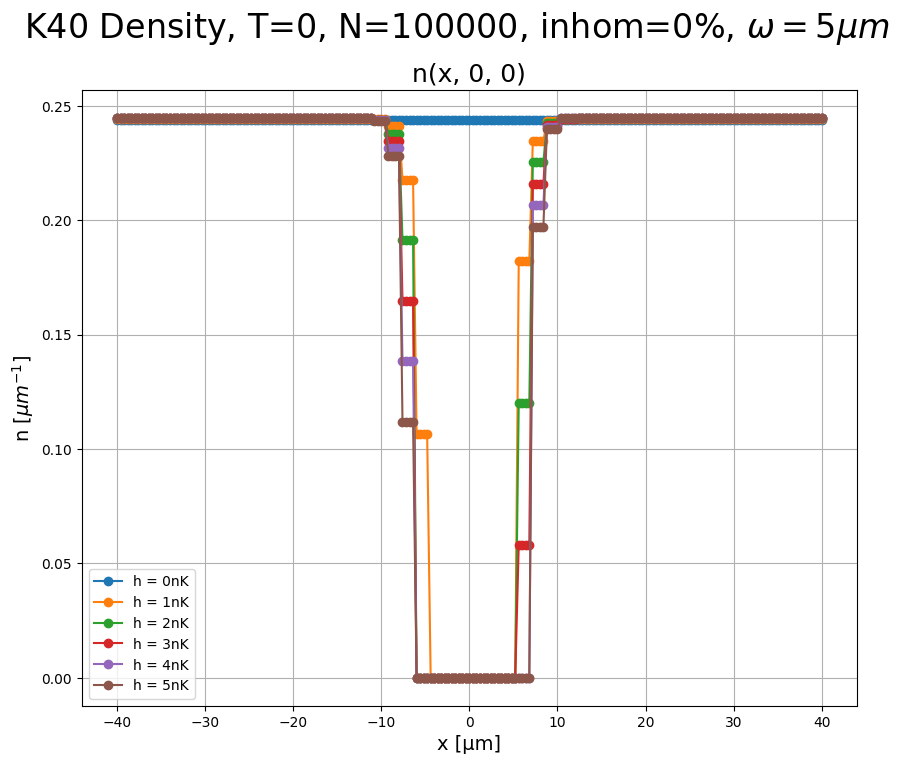

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.suptitle('K40 Density, T=0, N=100000, inhom=0%, $\omega = 5\mu m$', fontsize=24)

ax.set_xlabel('x [μm]', fontsize=14)
ax.set_ylabel(r'n [$μm^{-1}$]', fontsize=14)
ax.set_title('n(x, 0, 0)', fontsize=18)

num_points = 201
x = np.linspace(bgs[0].particle_props.domain[0, 0].value, bgs[0].particle_props.domain[0, 1].value, num_points)

for i, height in enumerate([0, 1, 2, 3, 4, 5]):
    ax.plot(x, bgs[i].spatial_basis_set.expand_coeffs(bgs[i].n_array, x, 0, 0), label='h = ' + str(height) + 'nK', marker='o')

ax.legend()
ax.grid(True)